In [18]:
# Seed value
seed_value= 7

# Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow
tensorflow.random.set_seed(seed_value)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tensorflow.config.set_visible_devices([], 'GPU')

tensorflow.compat.v1.disable_v2_behavior()
import pandas as pd
from tensorflow.compat.v1.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow_addons.layers import MultiHeadAttention
from tensorflow.compat.v1.keras.preprocessing.text import Tokenizer
from tensorflow.compat.v1.keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.initializers import Constant, RandomNormal
from tensorflow.compat.v1.keras.layers import concatenate, Layer, Convolution1D, Embedding, Dense, Flatten, MaxPooling1D, Input, Bidirectional, LSTM, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.compat.v1.keras.callbacks import EarlyStopping
import shap

In [10]:
def run(task, input_concat, model_type, i):
    
    '''
    task: string
        binary: Dataset with sentiment of postive and negative.
        multiclass: Dataset with sentiment of positive, neutral, and negative.
        
    input_concat: boolean
        True: The input is concatenated.
        False: The input is seperated.
    
    model_type: string
        CNN
        BiLSTM
        Transformer
        
    '''
    
    ### Dataset selection
    
    if task == 'multiclass':
        # dataset for multiclass
        df = pd.read_csv('data/geo_microblog.csv')
    else:
        # dataset for binary
        df = pd.read_csv('data/geo_microblog.csv')
        df = df[df.sentiment != 1]
        df.sentiment.replace(2, 1, inplace=True) # neutral

    ### Text processing
    
    # prepare tokenizer
    
    t = Tokenizer()
    t.fit_on_texts(df['text'])
    vocab_size = len(t.word_index) + 1
    
    # integer encode the documents
    
    encoded_docs = t.texts_to_sequences(df['text'])
    txtlen = 30
    loclen = 0
    
    # pad documents to a max length 
    
    padded_docs = pad_sequences(encoded_docs, txtlen, padding='post')

    ### Location processing
    
    # location = df['geonames'].apply(lambda x: pd.Series([i for i in x.split(',') if i not in [""]]).value_counts())
    # location = location.reindex(sorted(location.columns), axis=1).fillna(0)
    # location = location.values
    # np.save('microblog_multiclass_location.npy', location)
    if task == 'binary':
        location = np.load('variable/microblog_binary_location.npy')
    else:
        location = np.load('variable/microblog_multiclass_location.npy')
    loclen = location.shape[1]
        
    ### Prepare train and test set
        
    # merge txt and loc
    
    merge = np.concatenate((padded_docs, location),axis=1)
    
    # divide dataset to train and test set
    
    x_train, x_test, y_train, y_test = train_test_split(merge, df['sentiment'], test_size=0.3, random_state=100)
        
    if input_concat == False:
        # split train set to text and location
        x_train1 = x_train[:,:txtlen]
        x_train2 = x_train[:,-loclen:]
        
        # # split test set to text and location
        x_test1 = x_test[:,:txtlen]
        x_test2 = x_test[:,-loclen:]
        
    ### Pretrained word embedding
    
    # load the whole embedding into memory
    
    #embeddings_index = dict()
    #f = open('../glove.twitter.27B.200d.txt')
    #for line in f:
    #	values = line.split()
    #	word = values[0]
    #	coefs = asarray(values[1:], dtype='float32')
    #	embeddings_index[word] = coefs
    #f.close()
    #print('Loaded %s word vectors.' % len(embeddings_index))
    
    # create a weight matrix for words in training docs
    
    vector_dimension = 200
    #embedding_matrix = zeros((vocab_size, vector_dimension))
    #for word, i in t.word_index.items():
    #	embedding_vector = embeddings_index.get(word)
    #	if embedding_vector is not None:
    #		embedding_matrix[i] = embedding_vector
    
    if task == 'binary':
        embedding_matrix = np.load('variable/microblog_binary_embedding_matrix.npy')
    else:
        embedding_matrix = np.load('variable/microblog_multiclass_embedding_matrix.npy')
    
    ### Deep Learning model
    
    if input_concat == True:
        input_dimension = txtlen+loclen
        inputs = Input(shape=(input_dimension,))
        embedding_layer = Embedding(vocab_size, vector_dimension, embeddings_initializer=Constant(embedding_matrix), input_length=input_dimension)(inputs)
    else:
        inputText = Input(shape=(txtlen,))
        x = Embedding(vocab_size, vector_dimension, embeddings_initializer=Constant(embedding_matrix), input_length=txtlen)(inputText)
        inputLocation = Input(shape=(loclen,))
        y = Embedding(vocab_size, vector_dimension, embeddings_initializer=RandomNormal(), input_length=loclen)(inputLocation)
        embedding_layer = concatenate([x, y], axis=1)
    
    if model_type == "CNN":
        # CNN
        convolution_first = Convolution1D(filters=100, kernel_size=5, activation='relu')(embedding_layer)
        convolution_second = Convolution1D(filters=100, kernel_size=4, activation='relu')(convolution_first)
        convolution_third = Convolution1D(filters=100, kernel_size=3, activation='relu')(convolution_second)
        pooling_max = MaxPooling1D(pool_size=2)(convolution_third)
        flatten_layer = Flatten()(pooling_max)
        dense = Dense(20, activation="relu")(flatten_layer)
        if task == 'binary':
            outputs = Dense(units=1, activation='sigmoid')(dense)
        else:
            outputs = Dense(units=3, activation='softmax')(dense)
    
    if model_type == "BiLSTM":
        ### BiLSTM
        lstm_first = Bidirectional(LSTM(units=100))(embedding_layer)
        dense = Dense(20, activation="relu")(lstm_first)
        if task == 'binary':
            outputs = Dense(1, activation='sigmoid')(dense)
        else:
            outputs = Dense(3, activation='softmax')(dense)
            
    if model_type == "Transformer":
        ### Transformer
        num_heads = 2  # Number of attention heads
        ff_dim = 32  # Hidden layer size in feed forward network inside transformer
        
        if input_concat == True:
            embedding_layer_weighted = TokenAndPositionEmbedding(input_dimension, vocab_size, vector_dimension, Constant(embedding_matrix))
            x = embedding_layer_weighted(inputs)
        else:
            embedding_layer_weighted = TokenAndPositionEmbedding(txtlen, vocab_size, vector_dimension, Constant(embedding_matrix))
            x = embedding_layer_weighted(inputText)
            embedding_layer = TokenAndPositionEmbedding(loclen, vocab_size, vector_dimension, RandomNormal())
            y = embedding_layer(inputLocation)
            x = concatenate([x, y], axis=1)
        
        transformer_block = TransformerBlock(vector_dimension, num_heads, ff_dim)
        x = transformer_block(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(20, activation="relu")(x)
        if task == 'binary':
            outputs = Dense(1, activation='sigmoid')(x)
        else:
            outputs = Dense(3, activation='softmax')(x)
                
    
    # build model
    
    if input_concat == True: 
        model = Model(inputs, outputs)
    else:
        model = Model(inputs=[inputText, inputLocation], outputs=outputs)
    
    # compile model
    
    if task == 'binary':
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])    

    # early stopping
    
    early_stopping_monitor = EarlyStopping(patience=3) #patience: epochs the model can go without improving before we stop training

        
    if input_concat == True:
                    
        model.load_weights(f"saved/{task}/2_loc/concat/{model_type}/{task}_location_True_concat_{model_type}_{i}.h5")
         
        # evaluate model
        
        loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
        
    else:
        
        model.load_weights(f"saved/{task}/2_loc/both/{model_type}/{task}_location_True_both_{model_type}_{i}.h5")
        
        # evaluate model
        loss, accuracy = model.evaluate([x_test1, x_test2], y_test, verbose=1)
    
    return model, loss, accuracy, x_train, x_test

In [11]:
### Run 

task = 'binary'
input_concat = True
model_type = "CNN"
i = 0

model, loss, accuracy, x_train, x_test= run(task, input_concat, model_type, i)

In [12]:
accuracy

0.8518129

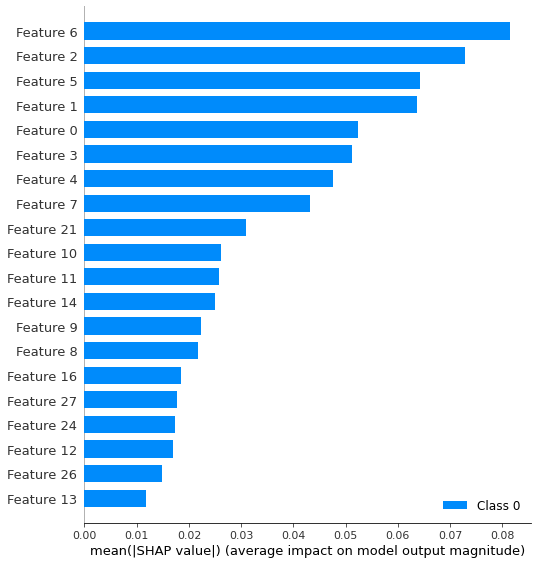

In [14]:
X_train_sample = shap.sample(x_train, 100)
X_test_sample = shap.sample(x_test, 20)
explainer = shap.DeepExplainer(model, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values, X_test_sample)